In [311]:
# imports
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import image
import os
import math
import random
import timeit

In [312]:
# 1.2 plot

def plot_lines(img, lines):
    res = img.copy()
    if lines is None:
        return res
    for i in range(len(lines)):
        rho = lines[i][0][0]
        theta = lines[i][0][1]
        a = np.cos(theta)
        b = np.sin(theta)
        x0 = rho * a
        y0 = rho * b
        pt1 = (int(x0 + 10000 * (-b)), int(y0 + 10000 * (a)))
        pt2 = (int(x0 - 10000 * (-b)), int(y0 - 10000 * (a)))
        cv.line(res, pt1, pt2, (0, 0, 255), 3, cv.LINE_AA)
    return res


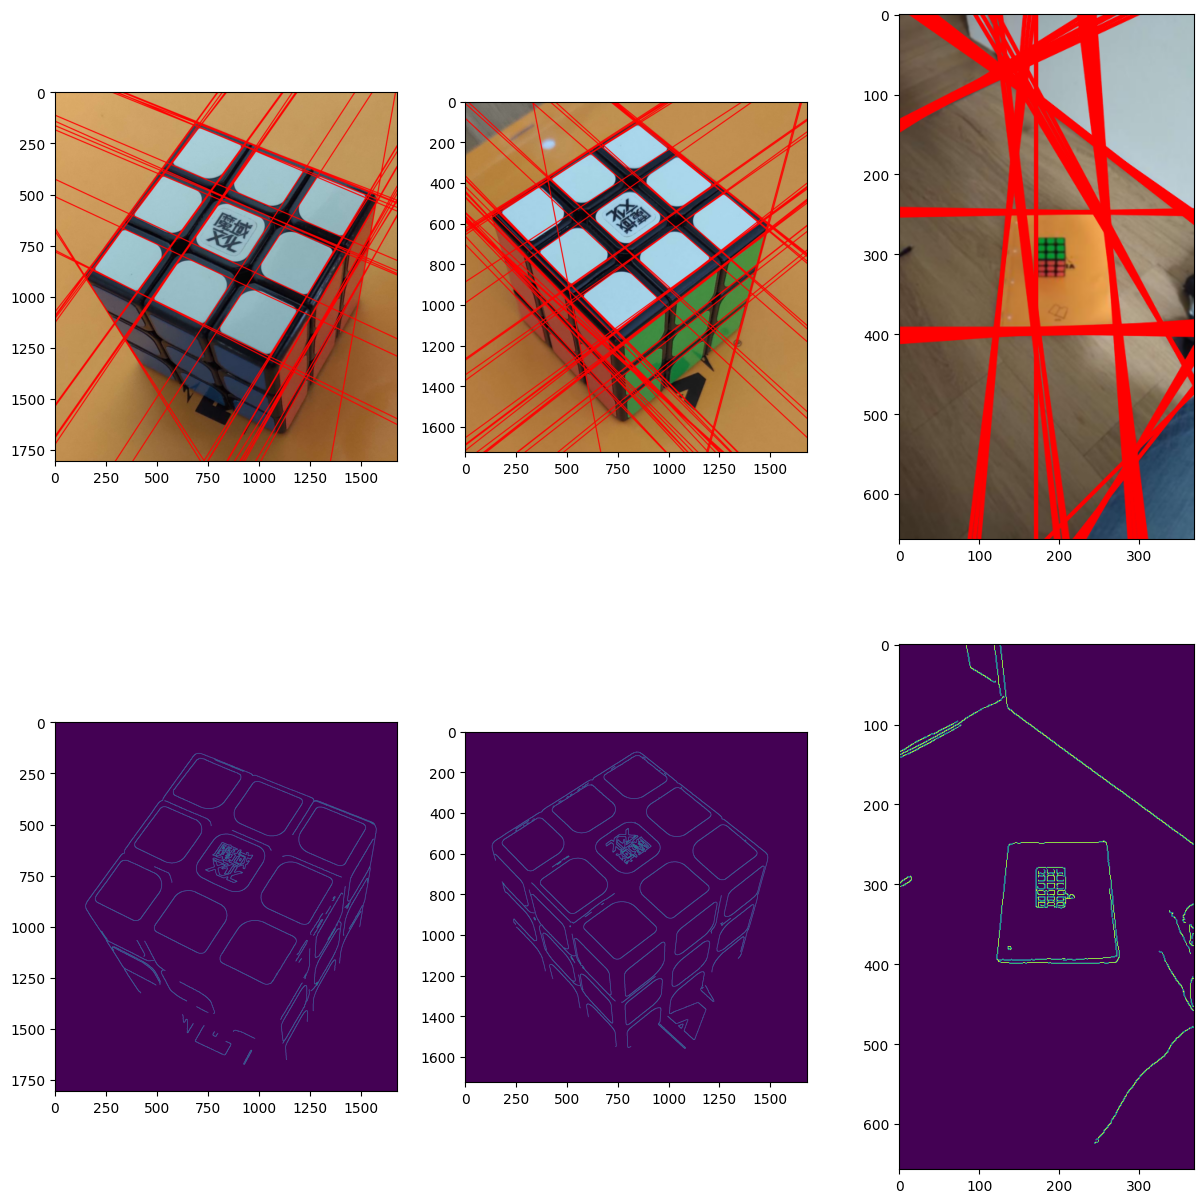

In [313]:
im1 = cv.imread('data/rubik1.jpg')
im2 = cv.imread('data/rubik2.jpg')
im3 = cv.imread('data/rubik5.jpg')

im1 = cv.GaussianBlur(im1, (5,5),1)
im2 = cv.GaussianBlur(im2, (5,5),1)
im3 = cv.GaussianBlur(im3, (5,5),1)

# 1.1 Hougs transform

canny_edge_1 = cv.Canny(im1, 80, 180, None, 3)
canny_edge_2 = cv.Canny(im2, 80, 180, None, 3)
canny_edge_3 = cv.Canny(im3, 50, 200, None, 3)

im1l = cv.HoughLines(canny_edge_1, 1, np.pi / 180.0, 150)
im2l = cv.HoughLines(canny_edge_2, 1, np.pi / 180.0, 150)
im3l = cv.HoughLines(canny_edge_3, 1, np.pi / 180.0, 50)

im1l = plot_lines(im1, im1l)
im2l = plot_lines(im2, im2l)
im3l = plot_lines(im3, im3l)


im1l = cv.cvtColor(im1l, cv.COLOR_BGR2RGB)
im2l = cv.cvtColor(im2l, cv.COLOR_BGR2RGB)
im3l = cv.cvtColor(im3l, cv.COLOR_BGR2RGB)

row = 2
col = 3
i = 1
plt.figure(figsize=(15, 15))
plt.subplot(row, col, i), plt.imshow(im1l)
i+=1
plt.subplot(row, col, i), plt.imshow(im2l)
i+=1
plt.subplot(row, col, i), plt.imshow(im3l)
i+=1
plt.subplot(row, col, i), plt.imshow(canny_edge_1)
i+=1
plt.subplot(row, col, i), plt.imshow(canny_edge_2)
i+=1
plt.subplot(row, col, i), plt.imshow(canny_edge_3)
i+=1
plt.show()

# A. Computing vanishing points: questions

## 1. The number of vanishing points

Between 0 and 3 finite vanishing points can be found from all possible images of a Rubik's cube. This is because our 3D world, once projected onto a 2D photography only has 3 degrees of freedom for the viewpoint: Left and right, up and down, forward and backward.

For the minimum, the least you can have is 0
- When you take a really zoomed in picture (inside a green square for exemple with no edge visible) because there will be no parallel lines. 
- When you take a perfect picture of a single face like a 2D square, because the lines on the Rubik's Cube will be parallel and will have the same depth (to the camera), the lines projected onto the image in 2D will be perfectly parallel and will never intersect to give vanishing points.

But for a more realistic picture where you can see only one whole face, there will be probably a rotation so, even if it will be a 2d square with only x and y axis, thoses axis parallel lines will converge to a single point for at least one axis event if it is really far, giving 1 vanishing points.





## 2 Is there a relation between number of visible faces and vanishing points?
Yes, there will be one vanishing point per axis transformed, with a maximum of three for a normal camera projection

## 3 Can you find 4 vanishing points in Rubik’s cube images? If yes, demonstrate with an image.

No, we will never be able to find a 4th vanishing point because the photo takes a 3D image (our world) onto a 2D image, so there are only 3 axes to be deformed by the perspective which means that we will only be able to fid 3 vanishing points at most. That's only 

If you change perspective to deform parallels (like a fish eye camera) you may be able to find more than 3 vanishing points, because line will become curved and will be able to intersect more than 3 times. this is not possible with a normal camera, but specialized fish eye cameras can do that and you will be able to find <a href="https://ieeexplore.ieee.org/document/5190078">4 vanishing points.</a>

## 4. Can you find a configuration with at least one vanishing point outside the image? 

Vanishing points can be outside of the image. Take the following picture for example:

<img src="data/rubik4.jpg" width="200"></img>

In [314]:
# sort lines by theta
def sort_lines(lines):
    lines = lines.tolist()
    lines.sort(key=lambda x: x[0][1])
    return np.array(lines)

def cleanLines(lines, threshold):
    cleaned = []
    thetaPrev = -1
    for i in range(len(lines)):
        rho = lines[i][0][0]
        theta = lines[i][0][1]
        if thetaPrev == -1 or abs(theta - thetaPrev) > threshold:
            if i > 0:
                thetaLast = cleaned[-1][0][1]
                cleaned.append(lines[i - 1])
                thetaLast2 = cleaned[-1][0][1]
                if thetaLast == thetaLast2:
                    cleaned.pop()
                    cleaned.pop()
                # print("rhop: ", rhoPrev, "thetap: ", thetaPrev)
            cleaned.append(lines[i])
            # print("rho: ", rho, "theta: ", theta)
        thetaPrev = theta
    return np.array(cleaned)

def print_cleaned(lineclean):
    for i in range(len(lineclean)):
        rho = lineclean[i][0][0]
        theta = lineclean[i][0][1]
        print("rho: ", rho, "theta: ", theta)



# 1.3 each group is two consecutive lines compute intersection between them

def compute_intersection(line1, line2):
    rho1 = line1[0][0]
    theta1 = line1[0][1]
    rho2 = line2[0][0]
    theta2 = line2[0][1]
    a = np.array([[np.cos(theta1), np.sin(theta1)], [np.cos(theta2), np.sin(theta2)]])
    b = np.array([rho1, rho2])
    x0, y0 = np.linalg.solve(a, b)
    return x0, y0

def compute_intersections(lines):
    intersections = []
    #compute l1, l2 then l3, l4 then l5, l6...
    for i in range(0, len(lines), 2):
        if i + 1 < len(lines):
            intersections.append(compute_intersection(lines[i], lines[i + 1]))
    return intersections

def print_intersections(intersections):
    for i in range(len(intersections)):
        print("x: ", intersections[i][0], "y: ", intersections[i][1])


im1l = sort_lines(im1l)
clean = cleanLines(im1l, 4)
intersections = compute_intersections(clean)

print_intersections(intersections)



x:  -1117.8672526149292 y:  228.17847068402568
x:  -651.1201131192154 y:  -3286.552722011381
x:  89.03729710380304 y:  -234.08720421275828
x:  -17.842700038711765 y:  -261.5503953995988
x:  1988.8707732816579 y:  -2500.387558267078
x:  -182.18499837862794 y:  159.24859092719367
x:  -214.03022087408183 y:  -184.87476397187268


## Computing vanishing point

To compute them, we sorted the lines by their angle, then clean the lines given by the hough transform to keep only two lines with approximately the same angle. Then we compute the intersection of the two lines to find the vanishing point. There is an error, and if more than one group represent the same vanishing point, because the lines are really close in angle, we have multiple points really far from each other. 

In [315]:
# part B : Computing fundamental matrix

# functions to get the matching points from the user
def get_points_from_user(image):
    # Function to handle mouse clicks
    def click_event(event, x, y, flags, param):
        if event == cv.EVENT_LBUTTONDOWN:
            points.append((x, y))
            cv.circle(param['image'], (x, y), 5, (0, 255, 0), -1)
            cv.imshow(param['window_name'], param['image'])

    # Display image
    cv.imshow('Image', image)

    # Initialize array to store points
    points = []

    # Set the mouse callback function
    cv.setMouseCallback('Image', click_event, {'image': image, 'window_name': 'Image'})

    # Wait until the user clicks on the image
    while True:
        key = cv.waitKey(1)
        if key == 13 or key == 27:  # Break if 'Enter' is pressed
            break

    # Convert points to NumPy array
    points_array = np.array(points)

    # Display the clicked points
    print("Clicked Points:", points_array)

    return points_array

def get_matching_points_from_user(image1, image2):
    print("provide points on the first image : \n")
    clicked_points_image1 = get_points_from_user(image1)
    print("provide corresponding points on the second image : \n")
    clicked_points_image2 = get_points_from_user(image2)
    cv.destroyAllWindows()
    return clicked_points_image1, clicked_points_image2

   




In [316]:
# get points from user using the above functions
image_left = cv.imread('data/rubik10.jpg')
image_right = cv.imread('data/rubik11.jpg')


# Check if images are loaded successfully
if image_left is None or image_right is None:
    print("Error: Could not load images.")
    exit()
    
points_left, points_right = get_matching_points_from_user(image_left, image_right)

# match the points together
def create_matching_points(array1, array2):
    matching_points = list(zip(array1, array2))
    return matching_points

# Create matching points
matching_points = create_matching_points(points_left, points_right)

provide points on the first image : 

Clicked Points: [[163 256]
 [215 209]
 [294 245]
 [251 295]
 [162 326]
 [234 362]
 [277 315]
 [ 58 183]]
provide corresponding points on the second image : 

Clicked Points: [[160 208]
 [245 176]
 [310 223]
 [219 261]
 [169 290]
 [215 341]
 [298 303]
 [166 144]]


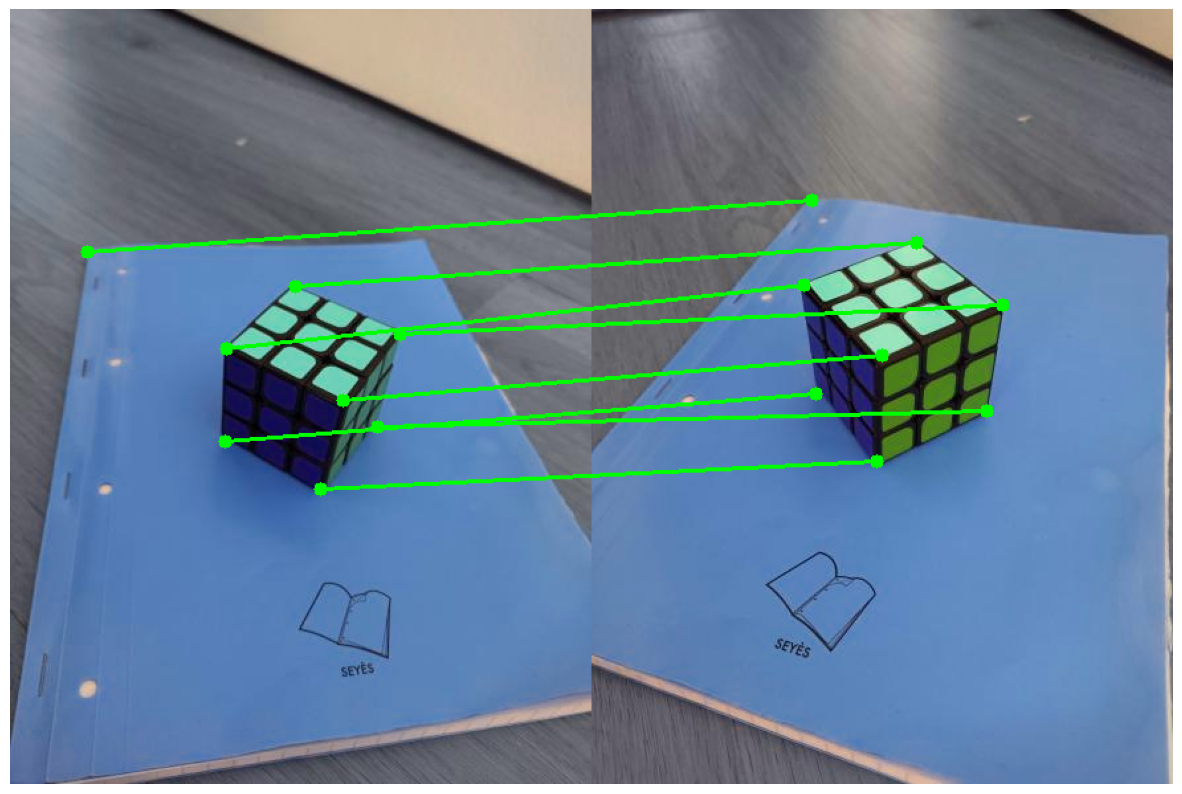

In [317]:
def display_matched_points(image1, image2, matching_points):
    # Concatenate the two images horizontally
    result_image = np.hstack((image1, image2.copy()))

    # Convert points to integer
    matching_points = np.int32(matching_points)

    # Draw lines connecting matched points
    for point1, point2 in matching_points:
        point2[0] += image1.shape[1]  # Adjust x-coordinate for the second image
        cv.line(result_image, tuple(point1), tuple(point2), (0, 255, 0), 2)

    # Display the result image in a plot
    plt.figure(figsize=(15, 15))
    plt.imshow(result_image)
    plt.axis('off')
    plt.show()
    

# Display the matched points
display_matched_points(image_left, image_right, matching_points)

In [318]:
# writing an epipolar constraint for each pair of points
# and rearranging it into a matrix such that Af = 0 (forming a linear system)

def pad_to_3D(points):
    return np.hstack((points, np.ones((points.shape[0], 1))))

def construct_A_matrix_row(point1, point2): #points of shape (x, y, 1) = to their coordinates in their image.
    x1, y1, _ = point1
    x2, y2, _ = point2

    A = np.array([
        x1 * x2, x1 * y2, x1,
        y1 * x2, y1 * y2, y1,
        x2, y2, 1
    ])

    return A

def estimate_fundamental_matrix_internal(points_image_1, points_image_2):
    A_matrix_list = [construct_A_matrix_row(point1, point2) for point1, point2 in zip(points_image_1, points_image_2)]
    A_final = np.vstack(A_matrix_list)
    #print("A_total:", A_final)

    # computing the fundamental matrix using svd

    _, _, V = np.linalg.svd(A_final)

    # Extract the smallest singular value
    f_vector = V[-1, :]
    f_matrix = f_vector.reshape(3, 3)

    # rank-2 constraint ensure the matrix is valid
    # Ensure rank-2 constraint by performing SVD on f_matrix
    U_f, D_f, Vt_f = np.linalg.svd(f_matrix)
    D_f[-1] = 0  # Set the smallest singular value to 0 to enforce rank-2 constraint
    f_matrix_rank2 = U_f @ np.diag(D_f) @ Vt_f

    #print("Fundamental Matrix (Rank-2):\n", f_matrix_rank2)

    return f_matrix_rank2

def estimate_fundamental_matrix(points_image_1_2D, points_image_2_2D):
    points_image_1_3D = pad_to_3D(points_image_1_2D)
    points_image_2_3D = pad_to_3D(points_image_2_2D)

    return estimate_fundamental_matrix_internal(points_image_1_3D, points_image_2_3D)

def estimate_fundamental_matrix_quality_internal(points_image_1, points_image_2, matrix):
    # print("The closer the values to 0, the better the matrix")

    # check correctness using the epipolar constraints
    for point1, point2 in zip(points_image_1, points_image_2):
        epipolar_constraint = point2 @ matrix @ point1
        # print("Epipolar Constraint:", epipolar_constraint)

    # the closest the values to 0 = the best estimated matrix
        
def estimate_fundamental_matrix_quality(points_image_1_2D, points_image_2_2D, matrix):
    points_image_1_3D = pad_to_3D(points_image_1_2D)
    points_image_2_3D = pad_to_3D(points_image_2_2D)

    estimate_fundamental_matrix_quality_internal(points_image_1_3D, points_image_2_3D, matrix)

fundamental_matrix = estimate_fundamental_matrix(points_left, points_right)
estimate_fundamental_matrix_quality(points_left, points_right, fundamental_matrix)


def compute_fundamental(x1, x2):
  '''Computes the fundamental matrix from corresponding points x1, x2 using
  the 8 point algorithm.'''
  x1 = pad_to_3D(x1)
  x2 = pad_to_3D(x2)
  n = x1.shape[1]
  if x2.shape[1] != n:
    raise ValueError('Number of points do not match.')

  # Normalization is done in compute_fundamental_normalized().
  A = np.zeros((n, 9))
  for i in range(n):
    A[i] = [x1[0, i] * x2[0, i],  x1[0, i] * x2[1, i],  x1[0, i] * x2[2, i],
            x1[1, i] * x2[0, i],  x1[1, i] * x2[1, i],  x1[1, i] * x2[2, i],
            x1[2, i] * x2[0, i],  x1[2, i] * x2[1, i],  x1[2, i] * x2[2, i],
           ]

  # Solve A*f = 0 using least squares.
  U, S, V = np.linalg.svd(A)
  F = V[-1].reshape(3, 3)

  # Constrain F to rank 2 by zeroing out last singular value.
  U, S, V = np.linalg.svd(F)
  S[2] = 0
  F = np.dot(U, np.dot(np.diag(S), V))
  return F / F[2, 2] 


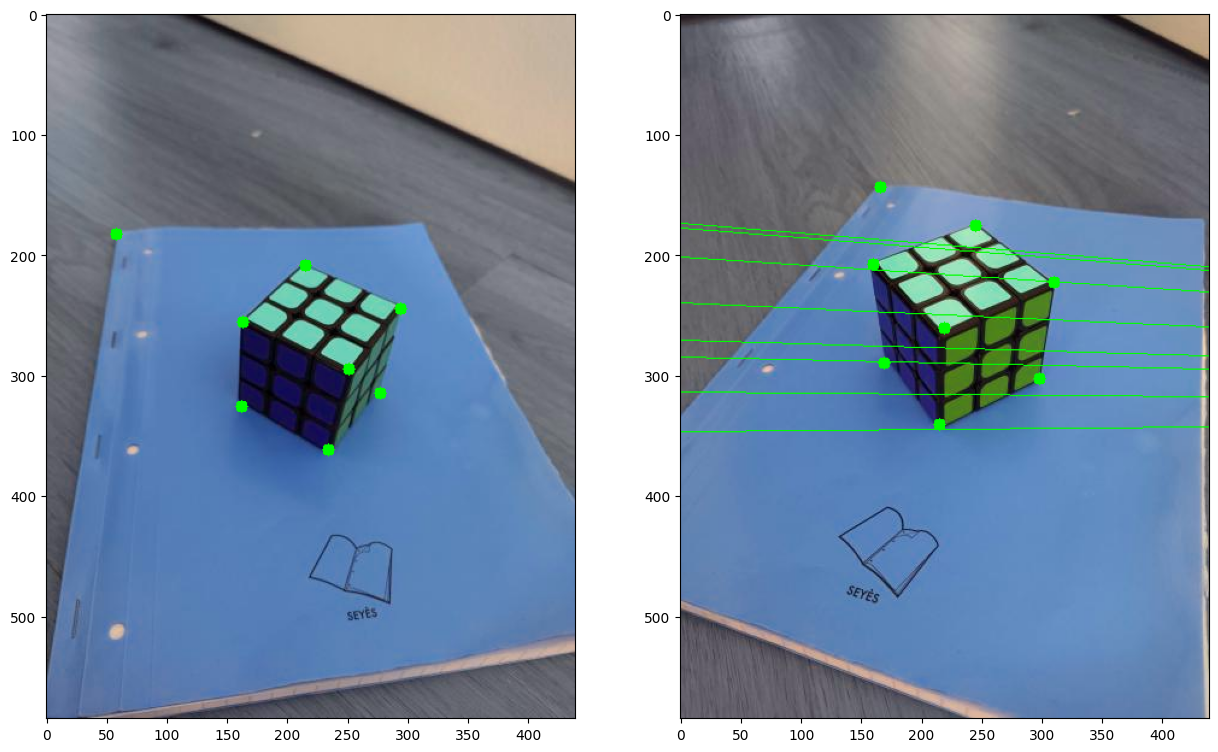

In [319]:
def display_epipolar_lines(image_2, points_image_2_2D, fundamental_matrix):
    # Choose corresponding points in the first image (you need to define these points)
    points = pad_to_3D(points_image_2_2D)

    points = points.reshape(-1, 1, 3)

    # Compute epipolar lines in the second image
    lines2 = cv.computeCorrespondEpilines(points, 1, fundamental_matrix)

    # Draw the epipolar lines on the second image
    image_right_with_lines = image_2.copy()
    for line in lines2:
        a, b, c = line[0]
        x0, y0, x1, y1 = map(int, [0, -c/b, image_2.shape[1], -(c+a*image_2.shape[1])/b])
        cv.line(image_right_with_lines, (x0, y0), (x1, y1), (0, 255, 0), 1)

    # Display the images
    plt.figure(figsize=(15, 15))
    plt.subplot(1, 2, 1), plt.imshow(image_left)
    plt.subplot(1, 2, 2), plt.imshow(image_right_with_lines)
    plt.show()

display_epipolar_lines(image_right, points_right, fundamental_matrix)

provide points on the first image : 



Clicked Points: [[165 257]
 [212 212]
 [293 244]
 [251 295]
 [160 320]
 [236 366]
 [277 319]
 [ 62 184]]
provide corresponding points on the second image : 

Clicked Points: [[164 212]
 [248 179]
 [310 227]
 [216 265]
 [170 289]
 [216 343]
 [298 303]
 [165 141]]
p1s:  [(165, 257), (212, 212), (293, 244), (251, 295), (160, 320), (236, 366), (277, 319), (62, 184)]
Fundamental Matrix:
 [[ 8.12477608e-07  1.29731681e-05 -4.39480242e-03]
 [-7.73360159e-06  3.71561986e-06  3.66577215e-03]
 [ 1.92209997e-03 -7.29276955e-03  1.00000000e+00]]


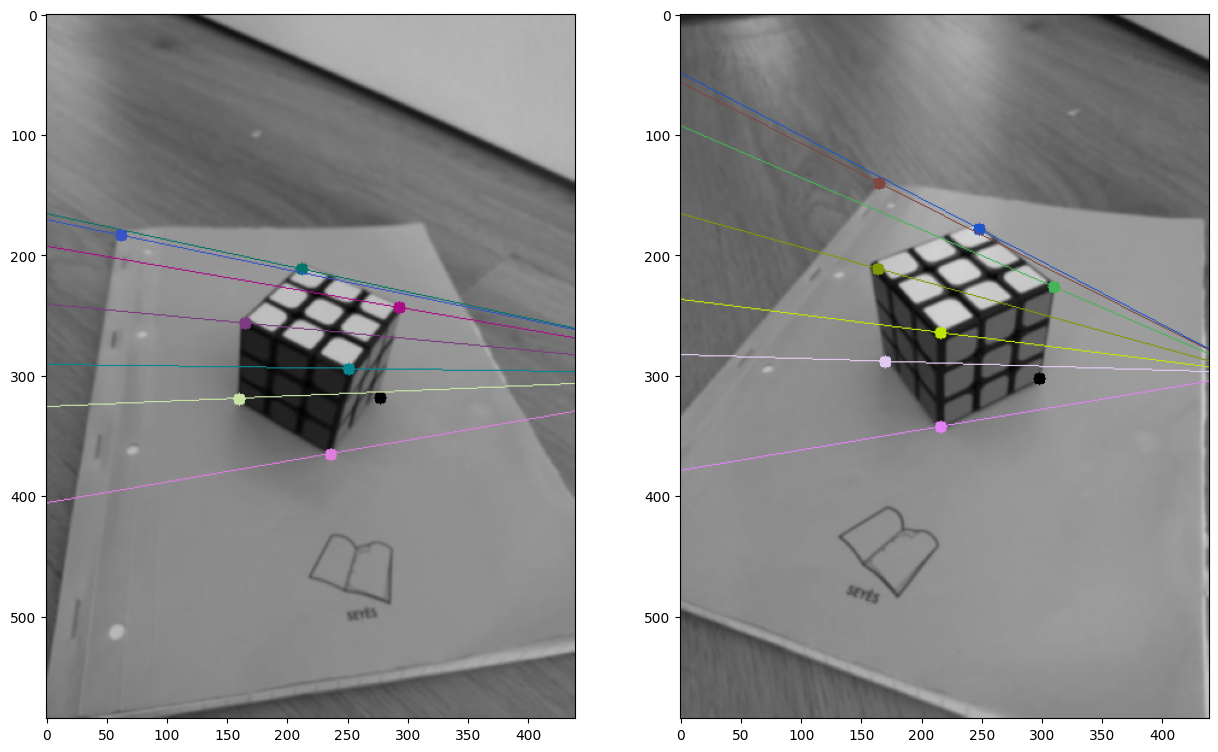

In [320]:
image_left = cv.imread('data/rubik10.jpg', cv.IMREAD_GRAYSCALE)
image_left = cv.GaussianBlur(image_left, (5,5),1)
image_right = cv.imread('data/rubik11.jpg', cv.IMREAD_GRAYSCALE)
image_right = cv.GaussianBlur(image_right, (5,5),1)

# sift = cv.SIFT_create()
# kp1, des1 = sift.detectAndCompute(image_left, None)
# kp2, des2 = sift.detectAndCompute(image_right, None)

# FLANN_INDEX_KDTREE = 1
# index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
# search_params = dict(checks=50)

# flann = cv.FlannBasedMatcher(index_params,search_params)
# matches = flann.knnMatch(des1, des2, k=2)

# ptsleft = []
# ptsright = []

# for i,(m,n) in enumerate(matches):
#     if m.distance < 0.8*n.distance:
#         ptsright.append(kp2[m.trainIdx].pt)
#         ptsleft.append(kp1[m.queryIdx].pt)

# print(ptsleft)

# ptsleft = np.int32(ptsleft)
# ptsright = np.int32(ptsright)


opl, opr = get_matching_points_from_user(image_left, image_right)
ptsleft = opl.copy()
ptsright = opr.copy()
p1s = []
p2s = []
for i in range(len(ptsleft)):
    p1s.append((ptsleft[i][0], ptsleft[i][1]))
    p2s.append((ptsright[i][0], ptsright[i][1]))


print("p1s: ", p1s)
ptsleft = np.int32(p1s)
ptsright = np.int32(p2s)

F, mask = cv.findFundamentalMat(ptsleft,ptsright,cv.FM_LMEDS)
print("Fundamental Matrix:\n", F)

# We select only inlier points
ptsleft = ptsleft[mask.ravel()==1]
ptsright = ptsright[mask.ravel()==1]

linesleft = cv.computeCorrespondEpilines(ptsright.reshape(-1,1,2), 2, F)
linesright = cv.computeCorrespondEpilines(ptsleft.reshape(-1,1,2), 1, F)

linesleft = linesleft.reshape(-1,3)
linesright = linesright.reshape(-1,3)

def drawlines(img1,img2,lines,pts1,pts2):
    ''' img1 - image on which we draw the epilines for the points in img2
        lines - corresponding epilines '''
    r,c = img1.shape
    img1 = cv.cvtColor(img1,cv.COLOR_GRAY2BGR)
    img2 = cv.cvtColor(img2,cv.COLOR_GRAY2BGR)
    for r,pt1,pt2 in zip(lines,pts1,pts2):
        color = tuple(np.random.randint(0,255,3).tolist())
        x0,y0 = map(int, [0, -r[2]/r[1] ])
        x1,y1 = map(int, [c, -(r[2]+r[0]*c)/r[1] ])
        img1 = cv.line(img1, (x0,y0), (x1,y1), color,1)
        img1 = cv.circle(img1,tuple(pt1),5,color,-1)
        img2 = cv.circle(img2,tuple(pt2),5,color,-1)
    return img1,img2

img5,img6 = drawlines(image_left,image_right,linesleft,ptsleft,ptsright)
img3,img4 = drawlines(image_right,image_left,linesright,ptsright,ptsleft)

plt.figure(figsize=(15, 15))
plt.subplot(121),plt.imshow(img5)
plt.subplot(122),plt.imshow(img3)
plt.show()








In [327]:
def normalize_points(points):
    # Normalize the points to have zero mean and a mean distance of sqrt(2)
    mean = np.mean(points, axis=0)
    std_dev = np.std(points)
    scale = np.sqrt(2) / std_dev
    translation_matrix = np.array([[scale, 0, -scale * mean[0]],
                                   [0, scale, -scale * mean[1]],
                                   [0, 0, 1]])
    normalized_points = np.dot(translation_matrix, np.vstack((points.T, np.ones(len(points)))))
    return normalized_points[:2].T, translation_matrix

def compute_fundamental_matrix(points1, points2):
    # Ensure points are 2D arrays
    points1 = np.array(points1)
    points2 = np.array(points2)

    if len(points1) < 8 or len(points2) < 8:
        raise ValueError("8 points ou rien")

    normalized_points1, T1 = normalize_points(points1)
    normalized_points2, T2 = normalize_points(points2)

    A = np.column_stack((normalized_points1[:, 0] * normalized_points2[:, 0],
                         normalized_points1[:, 0] * normalized_points2[:, 1],
                         normalized_points1[:, 0],
                         normalized_points1[:, 1] * normalized_points2[:, 0],
                         normalized_points1[:, 1] * normalized_points2[:, 1],
                         normalized_points1[:, 1],
                         normalized_points2[:, 0],
                         normalized_points2[:, 1],
                         np.ones(len(points1))))

    _, _, V = np.linalg.svd(A)
    F = V[-1].reshape(3, 3)

    U, S, V = np.linalg.svd(F)
    S[2] = 0
    F = np.dot(U, np.dot(np.diag(S), V))

    F = np.dot(T2.T, np.dot(F, T1))

    return F / F[2, 2]

def compute_fundamental_matrix_without_normalization(points1, points2):
    # Ensure points are 2D arrays
    points1 = np.array(points1)
    points2 = np.array(points2)

    # Check if the number of points is at least 8
    if len(points1) < 8 or len(points2) < 8:
        raise ValueError("At least 8 corresponding points are required to compute the fundamental matrix.")

    # Build the A matrix for the linear least squares problem
    A = np.column_stack((points1[:, 0] * points2[:, 0],
                         points1[:, 0] * points2[:, 1],
                         points1[:, 0],
                         points1[:, 1] * points2[:, 0],
                         points1[:, 1] * points2[:, 1],
                         points1[:, 1],
                         points2[:, 0],
                         points2[:, 1],
                         np.ones(len(points1))))

    # Solve for the singular vector corresponding to the smallest singular value
    _, _, V = np.linalg.svd(A)
    F = V[-1].reshape(3, 3)

    # Enforce rank 2 constraint on F
    U, S, V = np.linalg.svd(F)
    S[2] = 0
    F = np.dot(U, np.dot(np.diag(S), V))

    return F / F[2, 2]

print("pointsleft: ", opl)

my_fundamental_matrix = compute_fundamental_matrix_without_normalization(opl, opr)
my_fundamental_matrix_normalized = compute_fundamental_matrix(opl, opr)



print("my fundamental matrix:\n", my_fundamental_matrix)

display_epipolar_lines(image_right, ptsright, my_fundamental_matrix)

pointsleft:  [[165 257]
 [212 212]
 [293 244]
 [251 295]
 [160 320]
 [236 366]
 [277 319]
 [ 62 184]]


ValueError: shapes (2,8) and (4,3) not aligned: 8 (dim 1) != 4 (dim 0)

# B.1

Without normalizing the data, we can observe almost as many epipolar lines as there are
data points. None of these lines are parallel though. We should be getting parallel lines if
we had a precisely estimated fundamental matrix but because the matrix is not precisely estimated, 
our epipolar lines are not parallel.

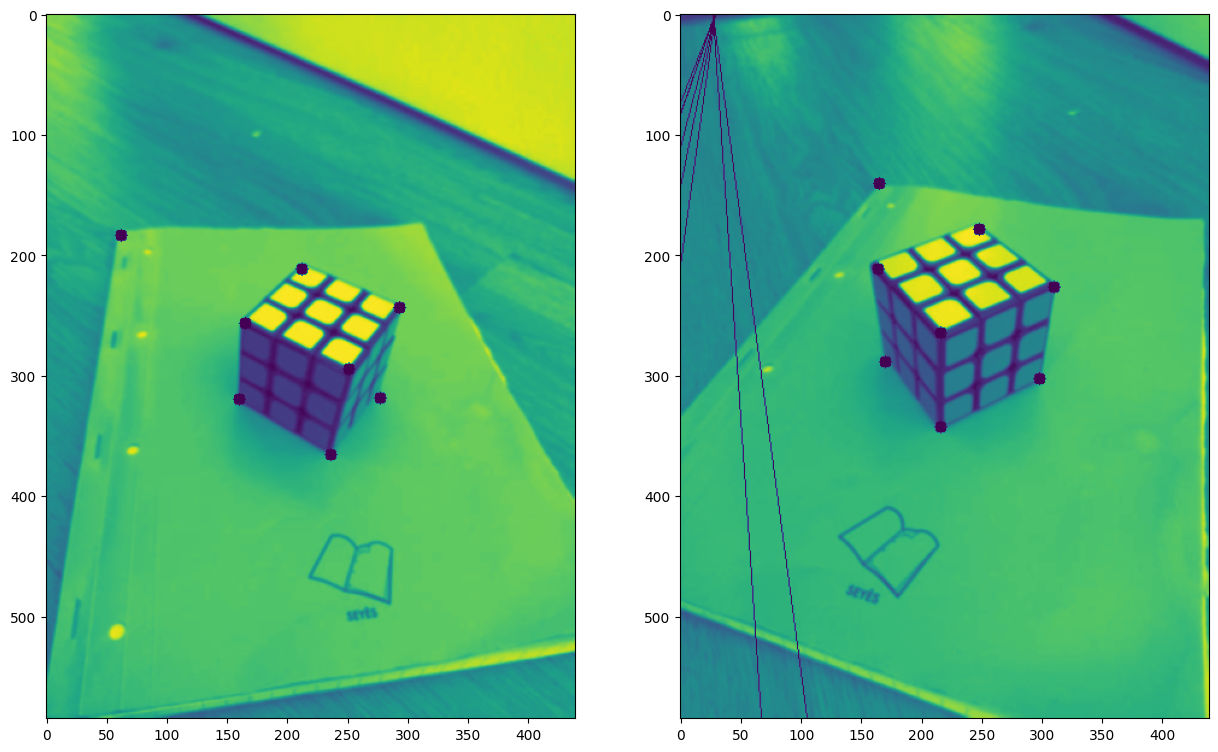

In [322]:
# recomputing with normalized data 
# 1) For each pair of matching points, we need to compute the average (another 2D point) of the points and subtract this average point from the 2 points
# 2) For each pair of matching points, compute the mean Euclidean distance from the origin for each pair of points. Scale each pair of points by dividing 
# each point by this mean distance.

# Step 1)
points_left_normalized = points_left.astype('float64')
points_right_normalized = points_right.astype('float64')

moyenne_left = np.mean(points_left_normalized, axis=0)
moyenne_right = np.mean(points_right_normalized, axis=0)

#Subtract the mean:
points_left_normalized -= moyenne_left
points_right_normalized -= moyenne_right

# Step 2)
mean_distance_left = np.mean(np.sqrt(np.sum(points_left_normalized ** 2, axis=1)))
mean_distance_right = np.mean(np.sqrt(np.sum(points_right_normalized ** 2, axis=1)))

scaling_factor_left = np.sqrt(2) / mean_distance_left
scaling_factor_right = np.sqrt(2) / mean_distance_right

points_left_normalized *= scaling_factor_left
points_right_normalized *= scaling_factor_right

fundamental_matrix_with_normalized = estimate_fundamental_matrix(points_left_normalized, points_right_normalized)
estimate_fundamental_matrix_quality(points_left, points_right, F)

display_epipolar_lines(image_right, points_right, fundamental_matrix_with_normalized)

##2. With data normalized

With the data normalized, we hardly measure any improvement in the quality of the fundamental matrix. Hard to explain why as normalizing the data should improve the quality of the fundamental matrix estimated from those points.

The quality should be improved by normalizing the data since the can reduce the impact of outliers. Without normalizing, the data, the outliers can disproportionately impact the rest of the points. Whe the outliers are normalized, the influence of outliers is greatly reduced.